In [1]:
from pathlib import Path
from random import shuffle

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [18]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from PubTabNetDataset import PubTabNet
# from TesseractUtils import im_to_data, scale

In [5]:
colors = list(mcolors.TABLEAU_COLORS.keys())
n_colors = len(colors)

In [11]:
data_dir = Path(r"C:\Users\stans\Documents\Projects\Datasets\pubtabnet.tar\pubtabnet\pubtabnet")
train_dir = data_dir / "train"
target_path = data_dir / "PubTabNet_2.0.0.jsonl"
TrainDataset = PubTabNet(train_dir, target_path)

In [12]:
im, _ = TrainDataset[0]

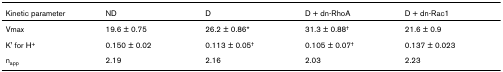

In [13]:
im

In [51]:
def data_2_input_matrix(im, data):
    W,H = im.size
    inp = []
    out = []
    for d in data:
        x,y,w,h = d["bbox"]
        x = x / W
        y = y / H
        w = w / W
        h = h / H
        
        inp.append([x,y,w,h])
        out.append([
            d["col_start"],
            d["row_start"]
        ])
        
    n_cols = max([x[0] for x in out])
    n_rows = max([x[1] for x in out])
    out = [[c/n_cols, r/n_rows] for c,r in out]
    z = list(zip(inp, out))
    shuffle(z)
    return list(zip(*z))

In [52]:
data_2_input_matrix(im, _)[1]

([0.25, 0.0],
 [0.0, 0.0],
 [0.0, 0.6666666666666666],
 [0.5, 0.3333333333333333],
 [0.75, 0.6666666666666666],
 [0.25, 0.3333333333333333],
 [0.25, 0.6666666666666666],
 [0.5, 0.0],
 [0.75, 1.0],
 [1.0, 0.6666666666666666],
 [0.0, 1.0],
 [0.5, 1.0],
 [0.75, 0.0],
 [0.75, 0.3333333333333333],
 [0.25, 1.0],
 [1.0, 0.3333333333333333],
 [0.5, 0.6666666666666666],
 [0.0, 0.3333333333333333],
 [1.0, 1.0],
 [1.0, 0.0])

In [69]:
# Hyper-parameters
# sequence_length = 256
input_size = 4
hidden_size = 128
output_size = 2
num_layers = 2
num_classes = 2
batch_size = 1
num_epochs = 2
learning_rate = 0.01
MAX_LENGTH = 256

In [70]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
model = AttnDecoderRNN(hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss(reduction='none')  # nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [62]:
# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(RNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)
    
#     def forward(self, x):
#         # Set initial hidden and cell states 
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
#         # Forward propagate LSTM
#         out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return out

# model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# # Loss and optimizer
# criterion = nn.MSELoss(reduction='none')  # nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [71]:
# Train the model
for epoch in range(num_epochs):
    for i in range(100):
        im, labels = TrainDataset[0]
        x, y = data_2_input_matrix(im, labels)
        
        x = torch.tensor(x).to(device)
        x = x.unsqueeze(0)
        y = torch.tensor(y).to(device)
        
        # Forward pass
        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.mean().backward()  # .backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step {}, Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss.mean()))

TypeError: forward() missing 2 required positional arguments: 'hidden' and 'encoder_outputs'

In [24]:
from random import shuffle

In [27]:
a = [1,2,3,4,5]
shuffle(a)
a

[5, 2, 1, 4, 3]

In [64]:
x, y = data_2_input_matrix(im, labels)
        
x = torch.tensor(x).to(device)
x = x.unsqueeze(0)
y = torch.tensor(y).to(device)
y_pred = model(x)

In [66]:
y_pred

tensor([[0.4986, 0.5022]], device='cuda:0', grad_fn=<AddmmBackward>)

In [65]:
y

tensor([[0.5000, 0.3333],
        [0.0000, 0.6667],
        [1.0000, 0.6667],
        [0.7500, 0.3333],
        [0.0000, 1.0000],
        [0.2500, 0.6667],
        [1.0000, 1.0000],
        [0.7500, 0.0000],
        [1.0000, 0.0000],
        [0.2500, 0.3333],
        [0.0000, 0.3333],
        [0.0000, 0.0000],
        [0.7500, 1.0000],
        [0.7500, 0.6667],
        [0.2500, 1.0000],
        [1.0000, 0.3333],
        [0.5000, 1.0000],
        [0.2500, 0.0000],
        [0.5000, 0.6667],
        [0.5000, 0.0000]], device='cuda:0')